In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q tqdm

import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm
import os

In [ ]:
def load_types(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        types = [line.strip() for line in f]
    return types

type_list = load_types('/content/drive/MyDrive/mini/release/ontology/types.txt')
type2id = {t: i for i, t in enumerate(type_list)}
id2type = {i: t for t, i in type2id.items()}

# Load char vocab
def load_char_vocab(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        chars = [line.strip() for line in f]
    return {ch: idx for idx, ch in enumerate(chars)}

char2idx = load_char_vocab('/content/drive/MyDrive/mini/release/ontology/char_vocab.english.txt')


In [ ]:
def load_jsonl(filepath, supervision_type,max_samples=None):
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for i,line in enumerate(f):
          if max_samples and i>=max_samples:
            break;
          else:
            ex = json.loads(line)
            ex['supervision'] = supervision_type
            data.append(ex)
    return data

el_train = load_jsonl('/content/drive/MyDrive/mini/release/distant_supervision/el_train.json', supervision_type='kb',max_samples=500000)
headword_train = load_jsonl('/content/drive/MyDrive/mini/release/distant_supervision/headword_train.json', supervision_type='head',max_samples=50000)

train_data = el_train + headword_train

dev_data = load_jsonl('/content/drive/MyDrive/mini/release/distant_supervision/el_dev.json', supervision_type='kb')

print(f"Train examples: {len(train_data)}")
print(f"Validation examples: {len(dev_data)}")


Train examples: 550000
Validation examples: 30854


In [ ]:
all_chars = set()
for item in train_data + dev_data:
    for word in item['left_context_token'] + item['right_context_token'] + item['mention_span'].split():
        all_chars.update(word)

char2idx = {c: i+2 for i, c in enumerate(sorted(all_chars))}
char2idx['<PAD>'] = 0
char2idx['<UNK>'] = 1


In [ ]:
def build_vocab(datasets):
    vocab = set()
    for data in datasets:
        for ex in data:
            vocab.update(ex['left_context_token'])
            vocab.update(ex['right_context_token'])
            if 'mention_span' in ex:
                vocab.update(ex['mention_span'].split())
    return vocab

vocab = ['<PAD>', '<UNK>'] + list(build_vocab([train_data, dev_data]))
word2idx = {w: i for i, w in enumerate(vocab)}

def load_glove(filepath, word2idx, emb_dim=300):
    embeddings = np.random.uniform(-0.1, 0.1, (len(word2idx), emb_dim))
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            if word in word2idx:
                embeddings[word2idx[word]] = np.array(list(map(float, parts[1:])))
    return torch.tensor(embeddings, dtype=torch.float)

glove_path = '/content/drive/MyDrive/mini/release/glove.6B.300d.txt'
embedding_matrix = load_glove(glove_path, word2idx)


In [ ]:
class EntityTypingDataset(Dataset):
    def __init__(self, data, word2idx, char2idx, type2id, max_len=128, max_char_len=16):
        self.data = data
        self.word2idx = word2idx
        self.char2idx = char2idx
        self.type2id = type2id
        self.max_len = max_len
        self.max_char_len = max_char_len

    def __len__(self):
        return len(self.data)

    def encode_tokens(self, tokens):
        token_ids = [self.word2idx.get(tok, self.word2idx['<UNK>']) for tok in tokens]
        if len(token_ids) > self.max_len:
            token_ids = token_ids[:self.max_len]
        else:
            token_ids += [self.word2idx['<PAD>']] * (self.max_len - len(token_ids))
        return token_ids

    def encode_chars(self, word):
        chars = [self.char2idx.get(c, self.char2idx['<UNK>']) for c in word]
        if len(chars) > self.max_char_len:
            chars = chars[:self.max_char_len]
        else:
            chars += [self.char2idx['<PAD>']] * (self.max_char_len - len(chars))
        return chars

    def __getitem__(self, idx):
        ex = self.data[idx]
        left = ex['left_context_token']
        mention = ex['mention_span'].split()
        right = ex['right_context_token']

        tokens = left + mention + right
        location = [0]*len(left) + [1]*len(mention) + [2]*len(right)

        token_ids = self.encode_tokens(tokens)
        location_ids = location[:self.max_len] + [0]*(self.max_len - len(location))

        mention_word = ' '.join(mention)
        char_ids = self.encode_chars(mention_word)

        label = torch.zeros(len(self.type2id))
        for y in ex['y_str']:
            if y in self.type2id:
                label[self.type2id[y]] = 1.0

        supervision = ex['supervision']

        return {
            'tokens': torch.tensor(token_ids, dtype=torch.long),
            'locations': torch.tensor(location_ids, dtype=torch.long),
            'chars': torch.tensor(char_ids, dtype=torch.long),
            'label': label,
            'supervision': supervision
        }


In [ ]:
class EntityTypingModel(nn.Module):
    def __init__(self, embedding_matrix, num_types, char_vocab_size, char_emb_dim=50, char_cnn_out=50, max_char_len=16, hidden_size=256, loc_emb_size=32):
        super().__init__()
        vocab_size, word_emb_dim = embedding_matrix.shape

        # Word Embedding
        self.word_embed = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        # Location Embedding
        self.loc_embed = nn.Embedding(3, loc_emb_size)

        # Character Embedding
        self.char_embed = nn.Embedding(char_vocab_size, char_emb_dim)
        self.char_cnn = nn.Conv1d(in_channels=char_emb_dim, out_channels=char_cnn_out, kernel_size=3, padding=1)

        # LSTM
        self.bilstm = nn.LSTM(word_emb_dim + loc_emb_size, hidden_size, bidirectional=True, batch_first=True)

        # Attention
        self.Wa = nn.Linear(hidden_size*2, hidden_size)
        self.Ua = nn.Linear(hidden_size, 1)

        # Type prediction
        self.fc = nn.Linear(hidden_size*2 + char_cnn_out, num_types)

    def forward(self, tokens, locations, chars):
        word_emb = self.word_embed(tokens)
        loc_emb = self.loc_embed(locations)
        x = torch.cat([word_emb, loc_emb], dim=-1)

        lstm_out, _ = self.bilstm(x)

        # Attention
        u = torch.relu(self.Wa(lstm_out))
        att = torch.softmax(self.Ua(u).squeeze(-1), dim=1)
        context = torch.sum(att.unsqueeze(-1) * lstm_out, dim=1)

        # Char CNN over mention
        char_emb = self.char_embed(chars)
        char_emb = char_emb.permute(0, 2, 1)
        char_feat = self.char_cnn(char_emb)
        char_feat, _ = torch.max(char_feat, dim=2)

        # Final representation
        final = torch.cat([context, char_feat], dim=-1)

        logits = self.fc(final)
        return logits


In [ ]:
train_dataset = EntityTypingDataset(train_data, word2idx, char2idx, type2id)
dev_dataset = EntityTypingDataset(dev_data, word2idx, char2idx, type2id)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = EntityTypingModel(embedding_matrix, num_types=len(type2id), char_vocab_size=len(char2idx)).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, train_loader, dev_loader, epochs=20):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch in tqdm(train_loader):
            tokens = batch['tokens'].to(device)
            locations = batch['locations'].to(device)
            chars = batch['chars'].to(device)
            labels = batch['label'].to(device)
            supervision = batch['supervision']

            optimizer.zero_grad()
            logits = model(tokens, locations, chars)
            criterion = nn.BCEWithLogitsLoss(reduction='none')

            loss = criterion(logits, labels)

            weights = torch.ones(logits.size(0)).to(device)
            for i, s in enumerate(supervision):
               if s == 'head':
                   weights[i] = 0.5

            loss = (loss.mean(dim=1) * weights).mean()

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        val_loss = evaluate(model, dev_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f}")
    torch.save(model.state_dict(), '/content/drive/MyDrive/mini/entity_model.pt')
    return train_losses, val_losses

In [ ]:
train_losses, val_losses = train_model(model, train_loader, dev_loader, epochs=10)

100%|██████████| 8594/8594 [11:03<00:00, 12.95it/s]


Epoch 1/10 - Train Loss: 0.0011 - Val Loss: 0.0007


100%|██████████| 8594/8594 [10:59<00:00, 13.04it/s]


Epoch 2/10 - Train Loss: 0.0004 - Val Loss: 0.0005


100%|██████████| 8594/8594 [10:55<00:00, 13.10it/s]


Epoch 3/10 - Train Loss: 0.0002 - Val Loss: 0.0005


100%|██████████| 8594/8594 [10:58<00:00, 13.05it/s]


Epoch 4/10 - Train Loss: 0.0002 - Val Loss: 0.0004


100%|██████████| 8594/8594 [10:57<00:00, 13.08it/s]


Epoch 5/10 - Train Loss: 0.0001 - Val Loss: 0.0004


100%|██████████| 8594/8594 [10:58<00:00, 13.06it/s]


Epoch 6/10 - Train Loss: 0.0001 - Val Loss: 0.0005


100%|██████████| 8594/8594 [10:58<00:00, 13.05it/s]


Epoch 7/10 - Train Loss: 0.0001 - Val Loss: 0.0005


100%|██████████| 8594/8594 [10:56<00:00, 13.08it/s]


Epoch 8/10 - Train Loss: 0.0001 - Val Loss: 0.0005


100%|██████████| 8594/8594 [10:55<00:00, 13.10it/s]


Epoch 9/10 - Train Loss: 0.0000 - Val Loss: 0.0006


100%|██████████| 8594/8594 [10:55<00:00, 13.10it/s]


Epoch 10/10 - Train Loss: 0.0000 - Val Loss: 0.0006


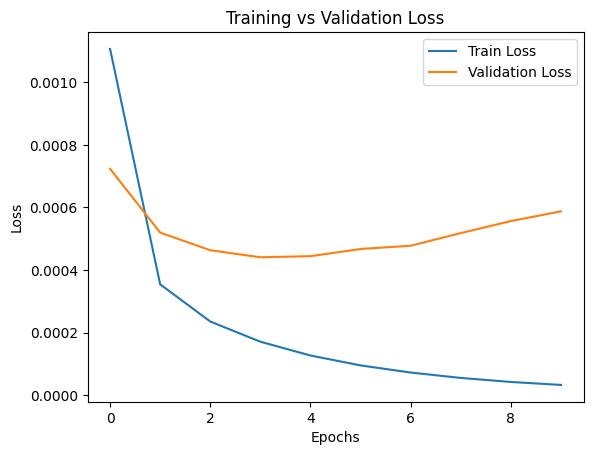

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [ ]:
model = EntityTypingModel(embedding_matrix, num_types=len(type2id), char_vocab_size=len(char2idx)).to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/mini/entity_model.pt', map_location=device))
model.eval()

EntityTypingModel(
  (word_embed): Embedding(417449, 300)
  (loc_embed): Embedding(3, 32)
  (char_embed): Embedding(88, 50)
  (char_cnn): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(1,))
  (bilstm): LSTM(332, 256, batch_first=True, bidirectional=True)
  (Wa): Linear(in_features=512, out_features=256, bias=True)
  (Ua): Linear(in_features=256, out_features=1, bias=True)
  (fc): Linear(in_features=562, out_features=10331, bias=True)
)

In [ ]:
def predict_user_input(model, sentence, mention, word2idx, char2idx, id2type, max_len=128, max_char_len=16, threshold=0.5):
    model.eval()

    tokens = sentence.split()
    mention_tokens = mention.split()

    try:
        start_idx = tokens.index(mention_tokens[0])
        end_idx = start_idx + len(mention_tokens) - 1
    except ValueError:
        start_idx = 0
        end_idx = 0

    left = tokens[:start_idx]
    right = tokens[end_idx + 1:]

    input_tokens = left + mention_tokens + right
    location_ids = [0]*len(left) + [1]*len(mention_tokens) + [2]*len(right)

    token_ids = [word2idx.get(tok, word2idx['<UNK>']) for tok in input_tokens]
    if len(token_ids) > max_len:
        token_ids = token_ids[:max_len]
        location_ids = location_ids[:max_len]
    else:
        token_ids += [word2idx['<PAD>']] * (max_len - len(token_ids))
        location_ids += [0] * (max_len - len(location_ids))

    mention_text = ' '.join(mention_tokens)
    char_ids = [char2idx.get(c, char2idx['<UNK>']) for c in mention_text]
    if len(char_ids) > max_char_len:
        char_ids = char_ids[:max_char_len]
    else:
        char_ids += [char2idx['<PAD>']] * (max_char_len - len(char_ids))

    tokens_tensor = torch.tensor([token_ids], dtype=torch.long).to(device)
    locations_tensor = torch.tensor([location_ids], dtype=torch.long).to(device)
    chars_tensor = torch.tensor([char_ids], dtype=torch.long).to(device)

    with torch.no_grad():
        logits = model(tokens_tensor, locations_tensor, chars_tensor)
        probs = torch.sigmoid(logits).squeeze(0)

    predicted_indices = torch.where(probs >= threshold)[0].tolist()

    predictions = [(id2type[idx], probs[idx].item()) for idx in predicted_indices]
    predictions.sort(key=lambda x: -x[1])

    return predictions

In [ ]:
sentence = "Microsoft was one of the first major tech companies to embrace cloud computing."
mention = "Microsoft"
predictions = predict_user_input(model, sentence, mention, word2idx, char2idx, id2type)

print(f"\nMention: {mention}\nPredicted Types:")
for label, score in predictions:
    print(f"{label} ({score:.4f})")


Mention: Microsoft
Predicted Types:
company (0.9999)


In [ ]:
sentence = "The new iPhone 13 is a great device."
mention = "iPhone 13"
predictions = predict_user_input(model, sentence, mention, word2idx, char2idx, id2type)

print(f"\nMention: {mention}\nPredicted Types:")
for label, score in predictions:
    print(f"{label} ({score:.4f})")


Mention: iPhone 13
Predicted Types:
product (1.0000)
car (0.9774)


In [ ]:
sentence = "Paris is known for its beautiful architecture and culture."
mention = "Paris"
predictions = predict_user_input(model, sentence, mention, word2idx, char2idx, id2type)

print(f"\nMention: {mention}\nPredicted Types:")
for label, score in predictions:
    print(f"{label} ({score:.4f})")


Mention: Paris
Predicted Types:
city (0.9997)
capital (0.9688)


In [ ]:
sentence = "Tom Cruise acted in the film Mission Impossible."
mention = "Tom Cruise"

predictions = predict_user_input(model, sentence, mention, word2idx, char2idx, id2type)

print(f"\nMention: {mention}\nPredicted Types:")
for label, score in predictions:
    print(f"{label} ({score:.4f})")


Mention: Tom Cruise
Predicted Types:
actor (0.9998)
producer (0.9824)


In [ ]:
sentence = "Steve Jobs founded Apple in 1976."
mention = "Steve Jobs"

predictions = predict_user_input(model, sentence, mention, word2idx, char2idx, id2type)

print(f"\nMention: {mention}\nPredicted Types:")
for label, score in predictions:
    print(f"{label} ({score:.4f})")


Mention: Steve Jobs
Predicted Types:
designer (0.9983)
businessman (0.9981)


In [ ]:
dev_dl = EntityTypingDataset(dev_data, word2idx, char2idx, type2id)

In [ ]:
def predict_batch(model, loader,max_batches=10, threshold=0.5):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
     for i, batch in enumerate(loader):
        if i >= max_batches:
            break

        tokens = batch['tokens'].to(device)
        locations = batch['locations'].to(device)
        chars = batch['chars'].to(device)
        labels = batch['label'].cpu().numpy()

        logits = model(tokens, locations, chars)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= threshold).astype(int)

        y_true.append(labels)
        y_pred.append(preds)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    return y_true, y_pred



In [ ]:
y_true, y_pred = predict_batch(model, dev_loader)

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Precision: 0.2582
Recall:    0.0531
F1 Score:  0.0881
